In [22]:
import json
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suffix for selecting benchmark results
suffix = "/read_avgnet/"

# Path to your benchmark results directory
results_dir = './results_store/_final/'
ec_pattern = results_dir + f'erasure{suffix}/_read_*_*.json'
replication_pattern = results_dir + f'replication{suffix}/_read_*_*.json'

# Helper to extract data from files

# Helper to extract data from files
def extract_data(files, system_type):
    data = []
    for file in files:
        # Updated regex: matches kbit, mbit, gbit
        match = re.search(r'_read_(.+?)_(\d+)vu(?:_([0-9]+(?:kbit|mbit|gbit)))?\.json', file)
        if not match:
            continue
        payload_size = match.group(1)
        if payload_size.endswith('b'):
            payload_size = payload_size[:-1]
        try:
            payload_size = int(payload_size)
        except ValueError:
            pass
        virtual_user = match.group(2)
        bandwidth = match.group(3) if match.group(3) else 'unlimited'
        with open(file) as f:
            j = json.load(f)
            # try summary.success_performance, else fallback to details.http_req_duration
            sp = j.get('summary', {}).get('success_performance')
            if sp:
                med = sp.get('med', 0)
                p90 = sp.get('p(90)', 0)
                avg = sp.get('avg', 0)
            else:
                dur = j.get('details', {}).get('http_req_duration', {}).get('values', {})
                med = dur.get('med', 0)
                p90 = dur.get('p(90)', 0)
                avg = dur.get('avg', 0)
            # extract request rate
            rate = j.get('summary', {}).get('reqs', {}).get('rate', 0)
            data.append({
                'system': system_type,
                'payload_size': payload_size,
                'virtual_user': int(virtual_user),
                'bandwidth': bandwidth,
                'med': med,
                'p90': p90,
                'avg': avg,
                'rate': rate
            })
    return data

def bandwidth_to_num(bw):
    if bw == 'unlimited':
        return float('inf')
    m = re.match(r'(\d+)(kbit|mbit|gbit)', bw)
    if not m:
        return float('inf')
    val, unit = int(m.group(1)), m.group(2)
    if unit == 'kbit':
        return val
    elif unit == 'mbit':
        return val * 1000
    elif unit == 'gbit':
        return val * 1000 * 1000
    return float('inf')

# Collect EC and Replication data
files_ec = glob.glob(ec_pattern)
files_replication = glob.glob(replication_pattern)
data = extract_data(files_ec, 'EC') + extract_data(files_replication, 'Replication')
df = pd.DataFrame(data)
if not df.empty:
    # Add bandwidth_num for correct sorting
    df['bandwidth_num'] = df['bandwidth'].apply(bandwidth_to_num)
    # Sort by payload_size, virtual_user, bandwidth_num, then system for grouped comparison
    df = df.sort_values(['payload_size', 'virtual_user', 'bandwidth_num', 'system'])
    df['combo'] = df.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu_{row['bandwidth']}", axis=1)
    df.reset_index(drop=True, inplace=True)
df

,system,payload_size,virtual_user,bandwidth,med,p90,avg,rate,bandwidth_num,combo
0,EC,200000,1,10mbit,9.124901,10.055491,10.860901,71.560057,10000,200000B_1vu_10mbit
1,Replication,200000,1,10mbit,2.551200,3.139400,2.985204,172.481319,10000,200000B_1vu_10mbit
2,EC,200000,1,25mbit,8.878701,10.085901,27.179235,32.630497,25000,200000B_1vu_25mbit
3,Replication,200000,1,25mbit,2.214601,2.711220,2.354469,195.552406,25000,200000B_1vu_25mbit
4,EC,200000,1,40mbit,8.708501,9.745851,11.303761,69.505690,40000,200000B_1vu_40mbit
5,Replication,200000,1,40mbit,2.206701,2.701601,2.305885,197.046616,40000,200000B_1vu_40mbit
6,EC,200000,1,55mbit,8.527501,9.542181,10.762659,72.170053,55000,200000B_1vu_55mbit
7,Replication,200000,1,55mbit,2.203500,2.690460,2.293517,198.336889,55000,200000B_1vu_55mbit
8,EC,200000,1,70mbit,8.179301,9.215161,14.392082,56.709423,70000,200000B_1vu_70mbit
9,Replication,200000,1,70mbit,2.144900,2.622800,2.230576,200.676736,70000,200000B_1vu_70mbit


/tmp/ipykernel_350098/1661755616.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1661755616.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1661755616.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1661755616.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


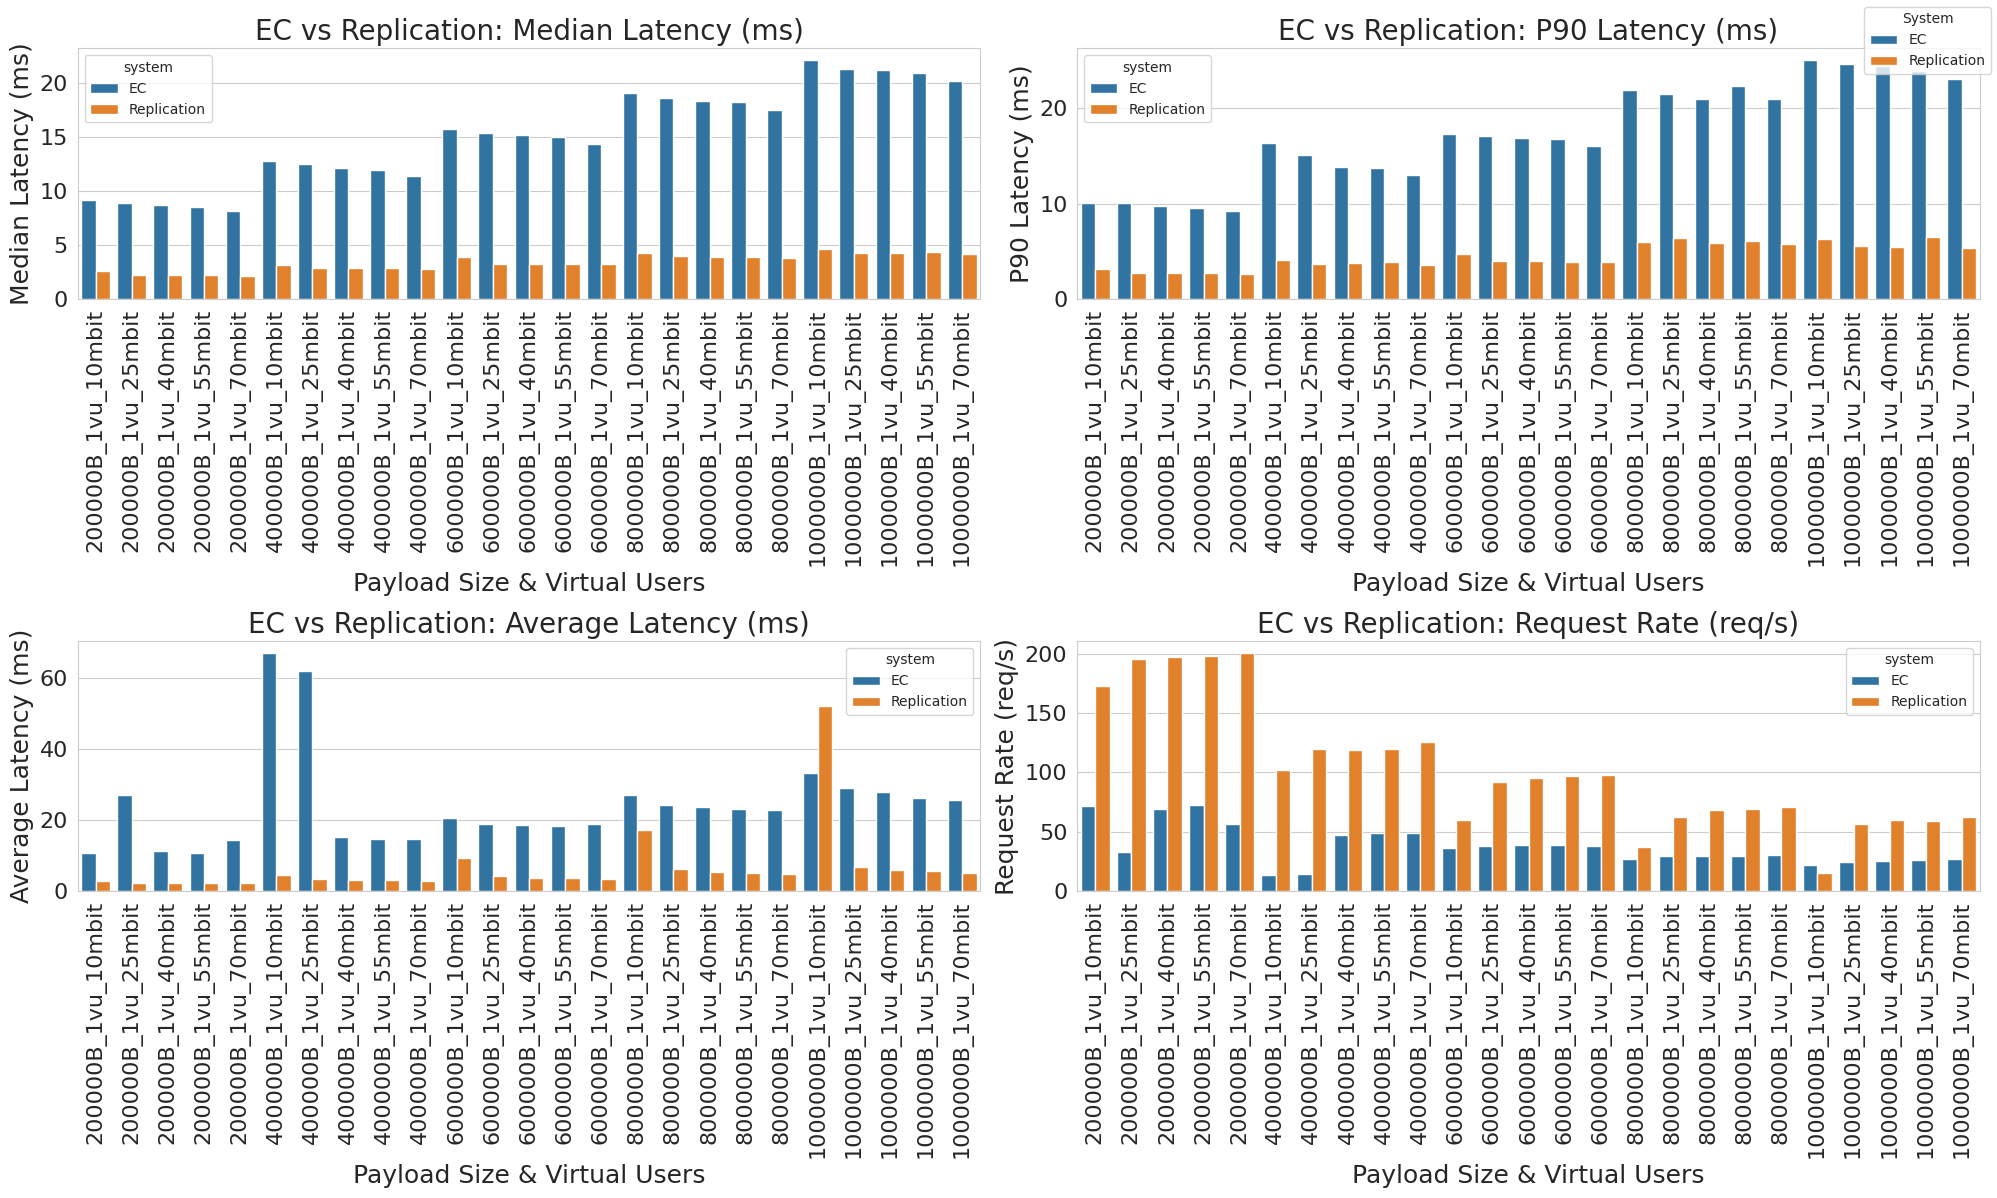

In [23]:
# Plotting: Compare EC vs Replication for each metric, grouped by (payload_size, virtual_user)
sns.set_style("whitegrid")
metrics = ['med', 'p90', 'avg', 'rate']
metric_titles = {
    'med': 'Median Latency (ms)',
    'p90': 'P90 Latency (ms)',
    'avg': 'Average Latency (ms)',
    'rate': 'Request Rate (req/s)'
}

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    sns.barplot(
        data=df,
        x='combo',
        y=metric,
        hue='system',
        ci=None,
        dodge=True,
        ax=ax
    )
    ax.set_title(f'EC vs Replication: {metric_titles[metric]}', fontsize=20)
    ax.set_xlabel('Payload Size & Virtual Users', fontsize=18)
    ax.set_ylabel(metric_titles[metric], fontsize=18)
    ax.tick_params(axis='x', rotation=90, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

# single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='System', loc='upper right')

fig.tight_layout()
plt.show()

In [24]:
# Create grouped visualizations for bandwidth, payload size, and virtual users

# First, let's check what distinct values we have for each parameter
print(f"Unique bandwidth values: {df['bandwidth'].unique()}")
print(f"Unique payload sizes: {df['payload_size'].unique()}")
print(f"Unique virtual users: {df['virtual_user'].unique()}")

Unique bandwidth values: ['10mbit' '25mbit' '40mbit' '55mbit' '70mbit']
Unique payload sizes: [ 200000  400000  600000  800000 1000000]
Unique virtual users: [1]


/tmp/ipykernel_350098/1687059888.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(
/tmp/ipykernel_350098/1687059888.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1687059888.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(
/tmp/ipykernel_350098/1687059888.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the sam

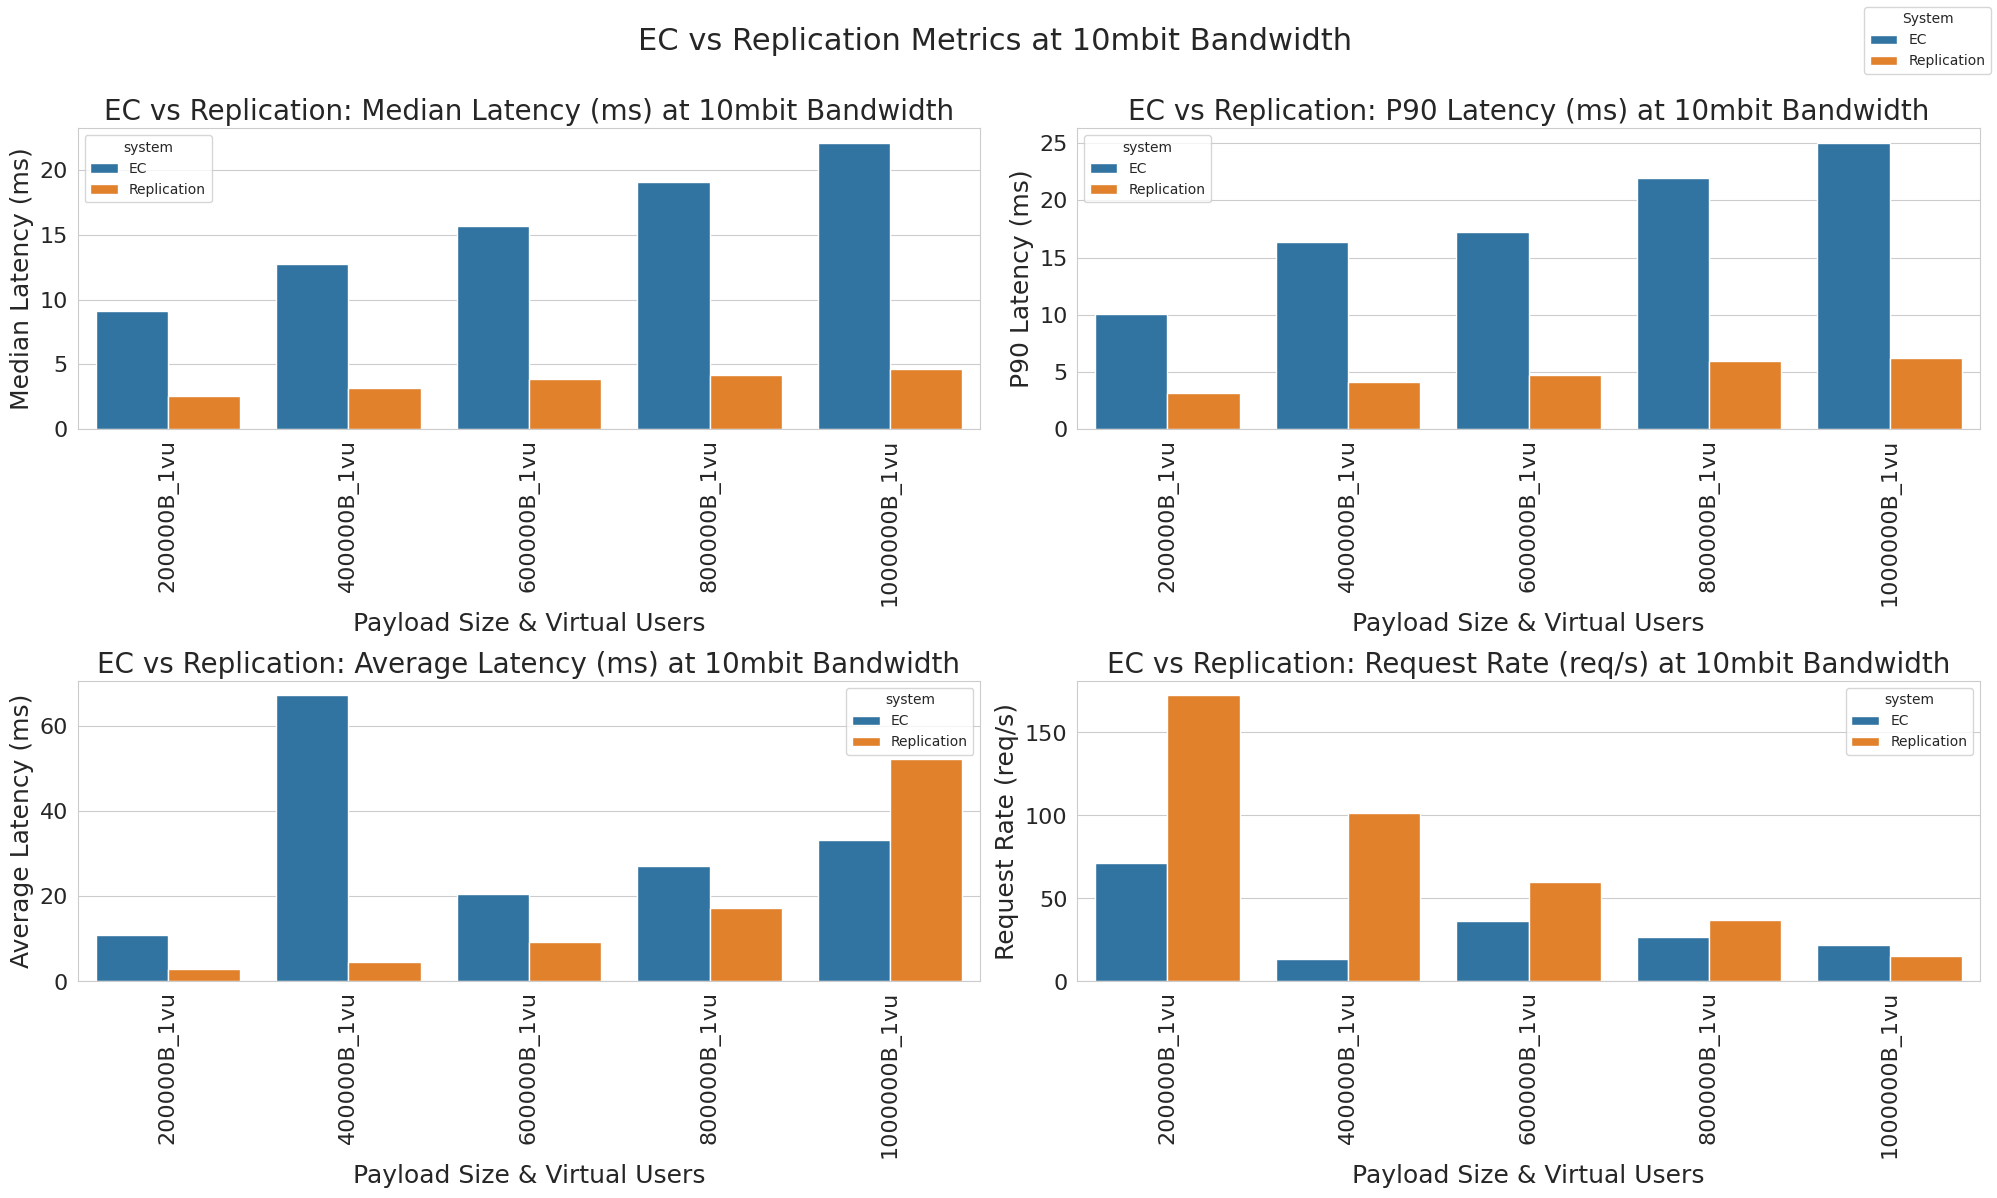

/tmp/ipykernel_350098/1687059888.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(
/tmp/ipykernel_350098/1687059888.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1687059888.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(
/tmp/ipykernel_350098/1687059888.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the sam

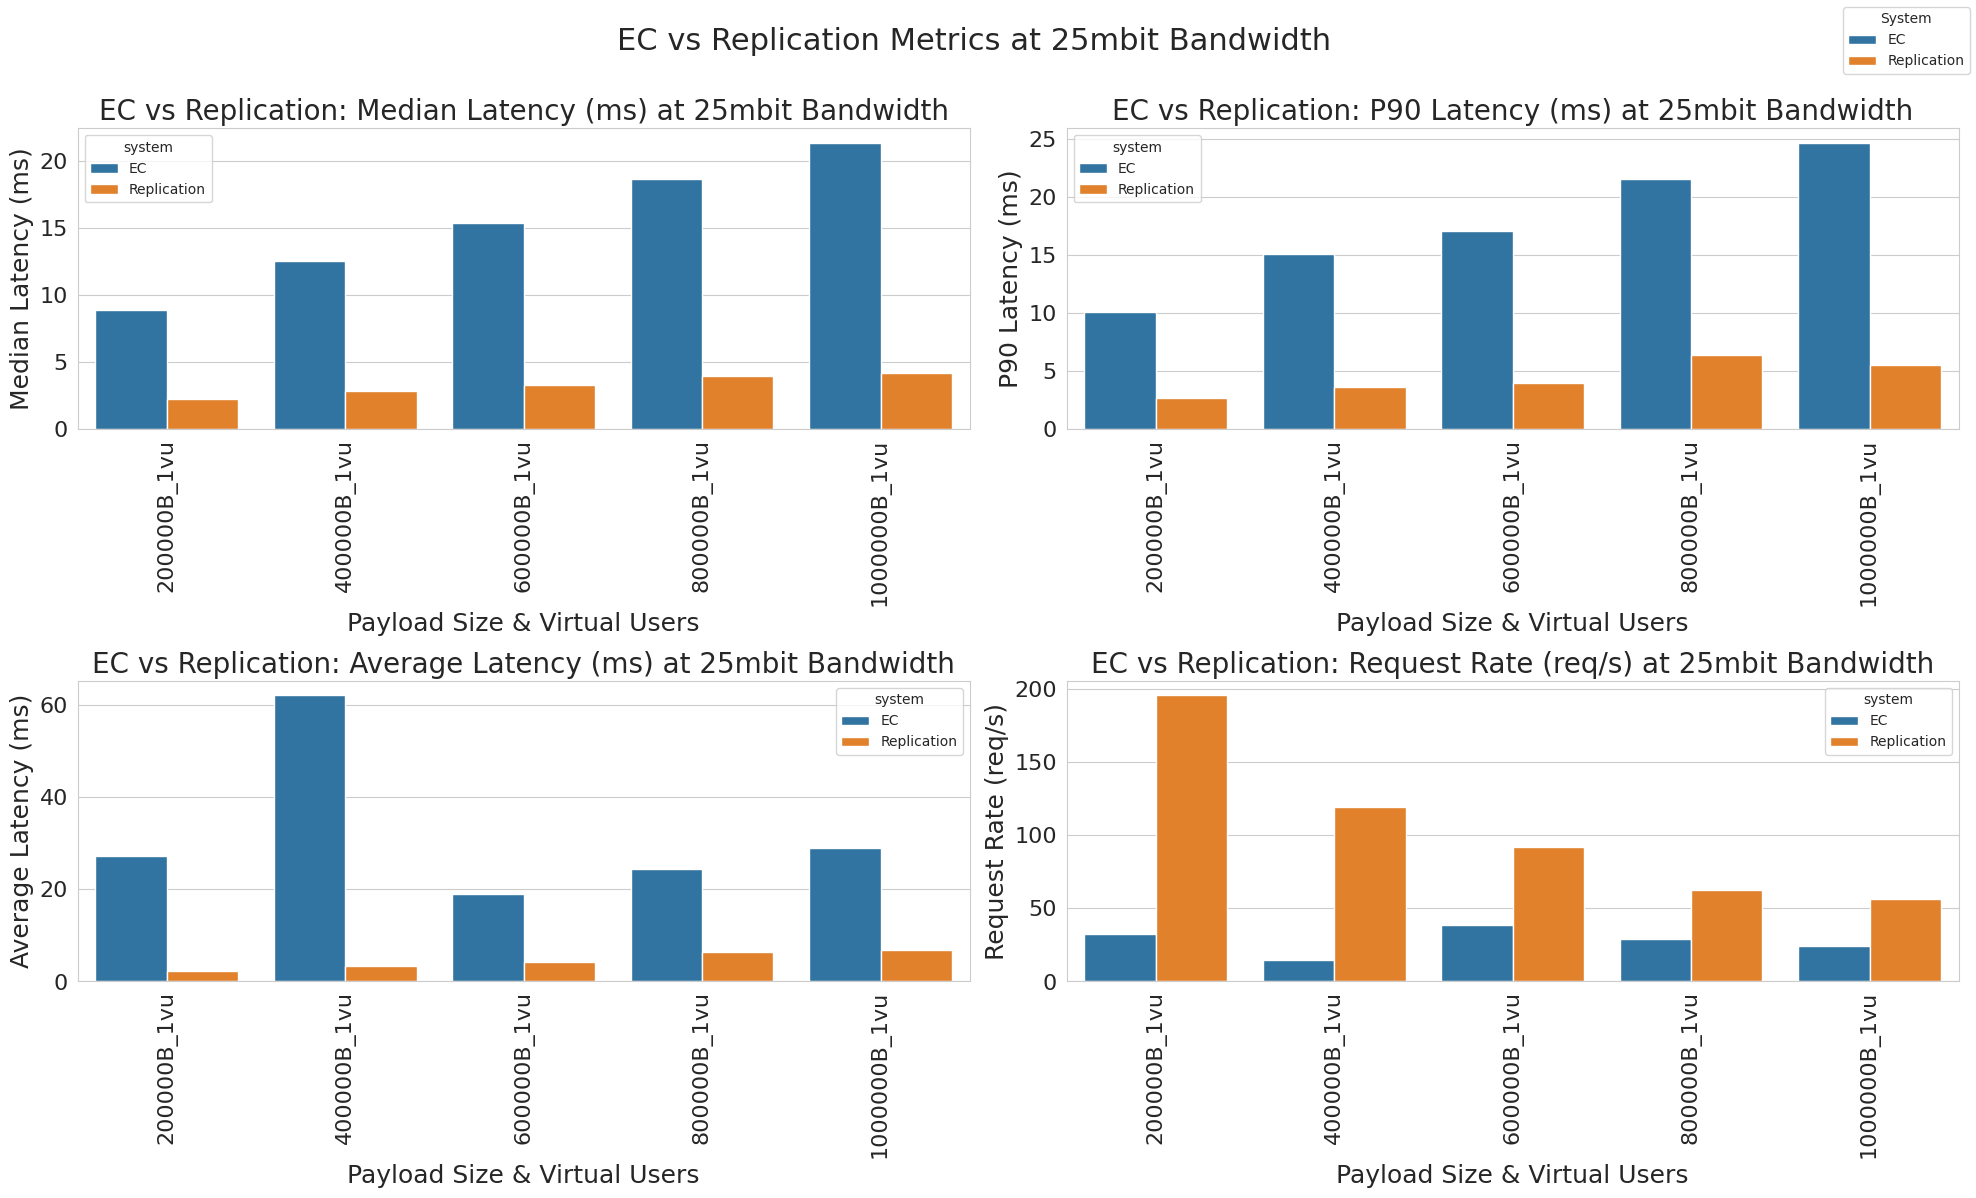

/tmp/ipykernel_350098/1687059888.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(
/tmp/ipykernel_350098/1687059888.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1687059888.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(
/tmp/ipykernel_350098/1687059888.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the sam

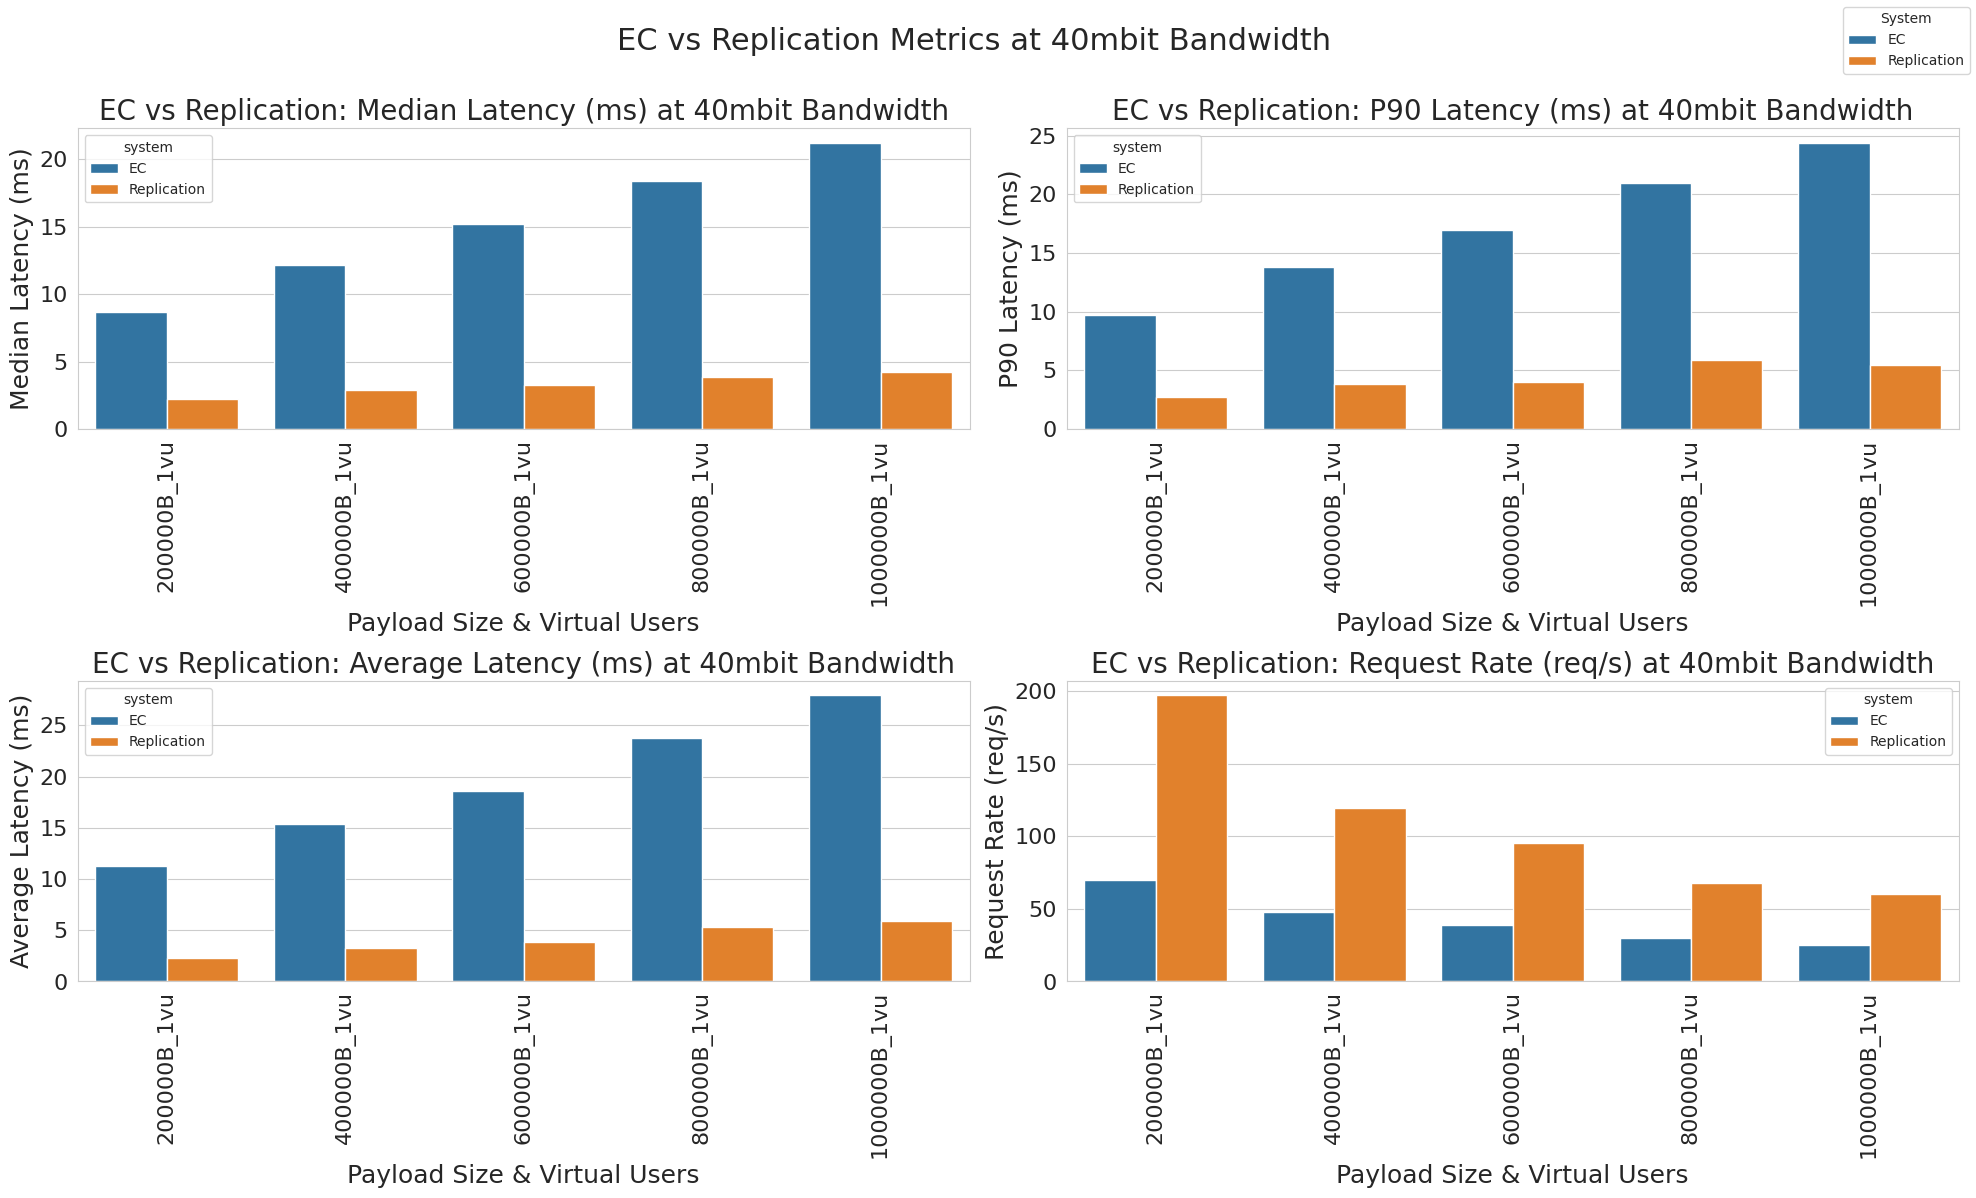

/tmp/ipykernel_350098/1687059888.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(
/tmp/ipykernel_350098/1687059888.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1687059888.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(
/tmp/ipykernel_350098/1687059888.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the sam

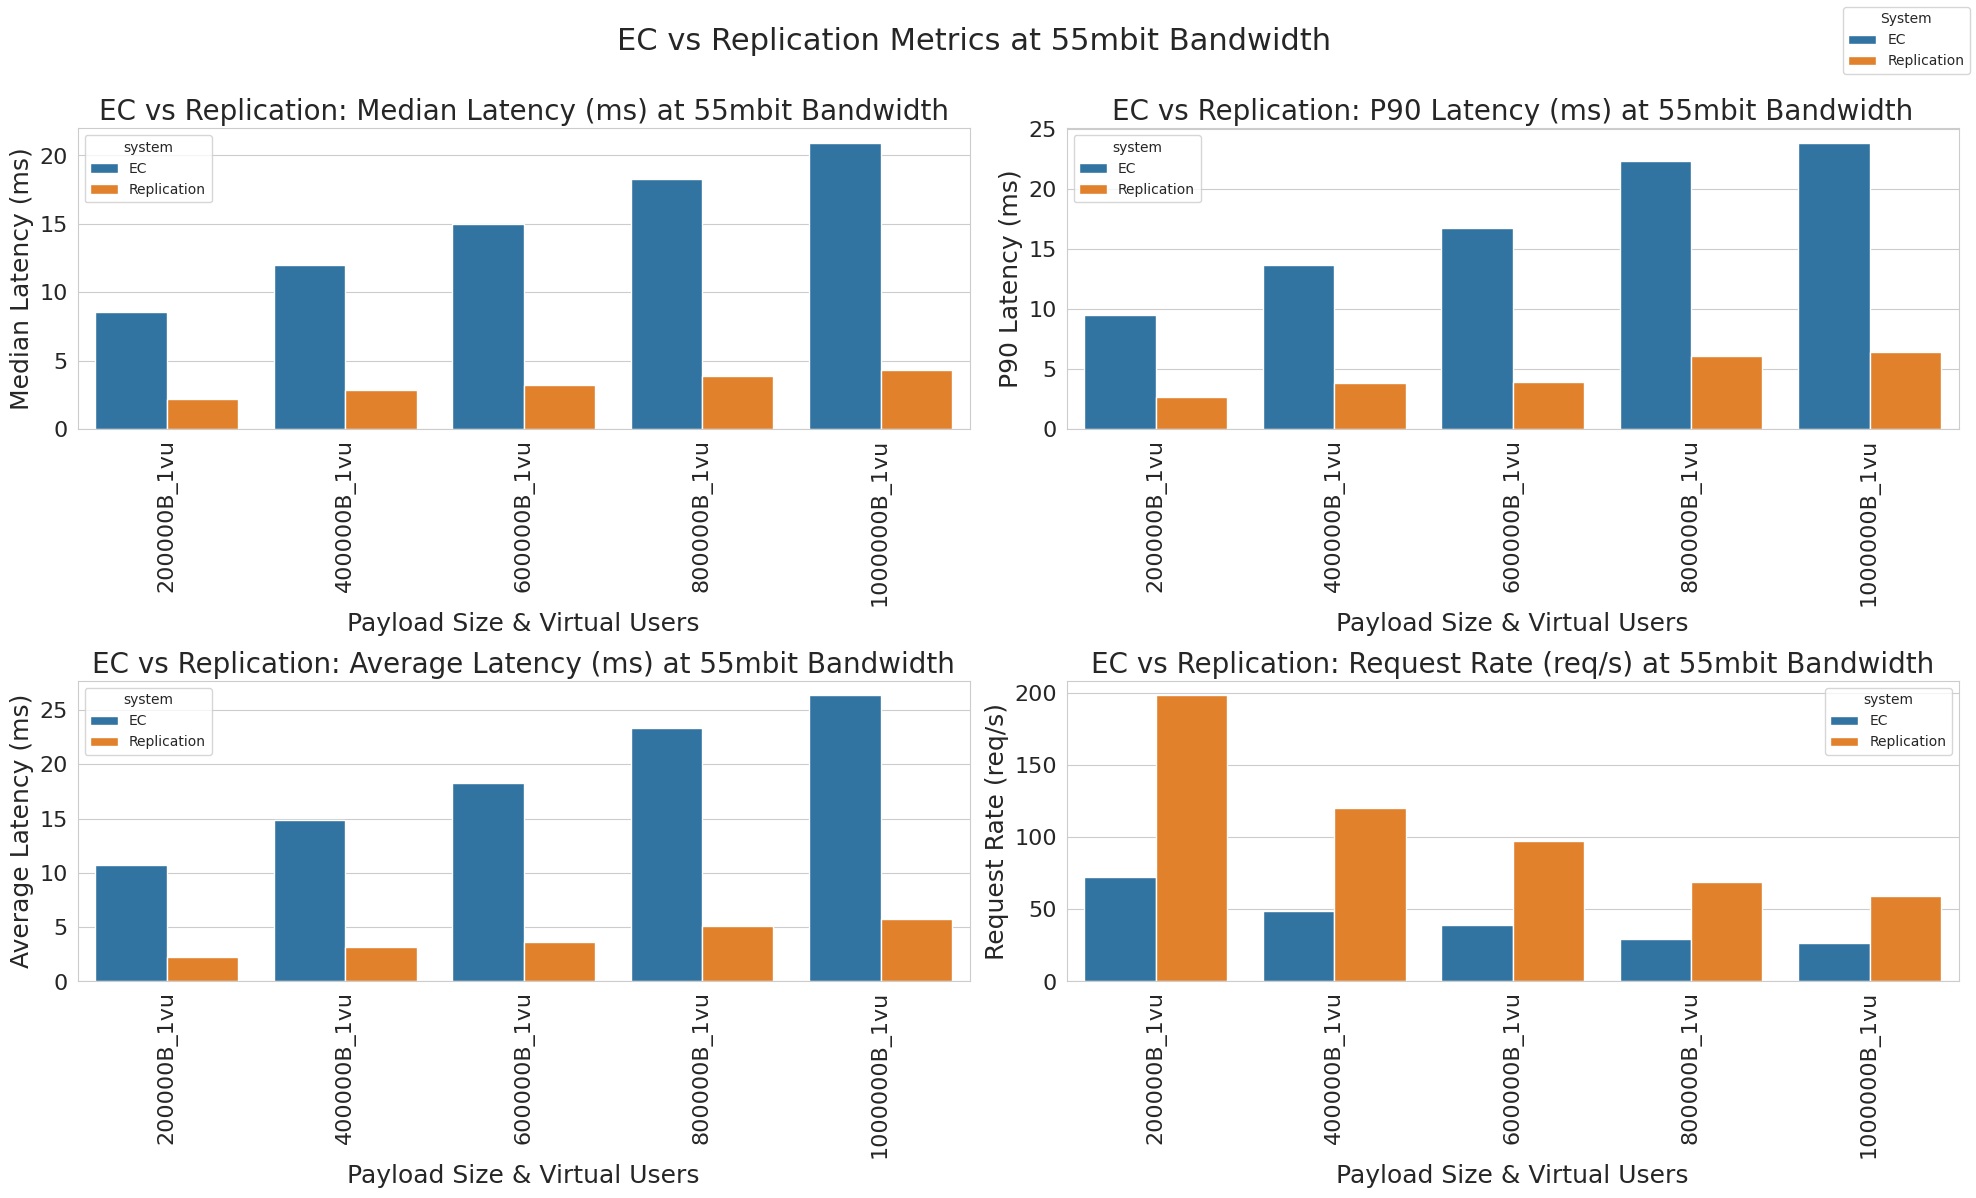

/tmp/ipykernel_350098/1687059888.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(
/tmp/ipykernel_350098/1687059888.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1687059888.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(
/tmp/ipykernel_350098/1687059888.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the sam

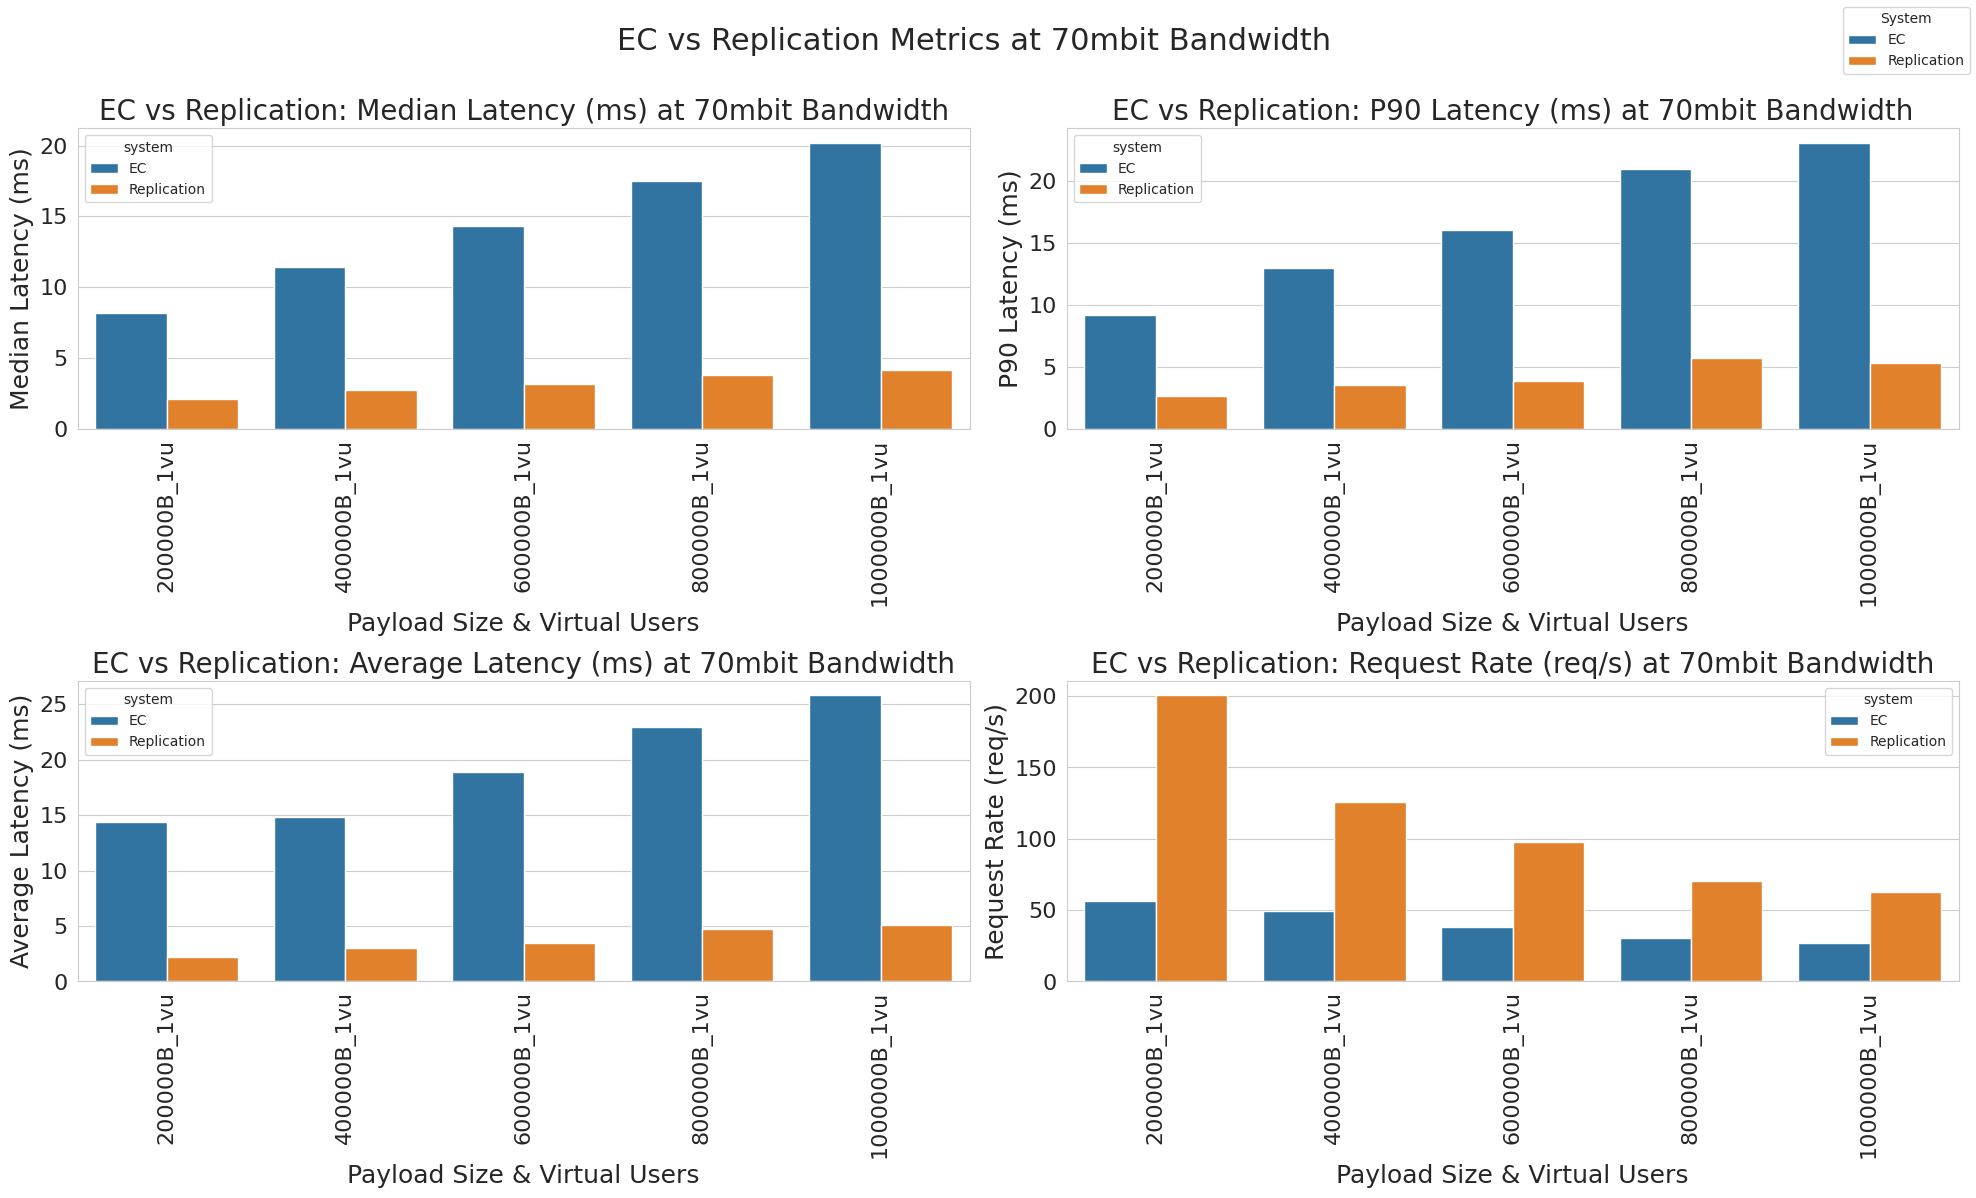

In [25]:
# 1. Grouping by bandwidth
def plot_by_bandwidth():
    # Sort bandwidths numerically using bandwidth_num
    bw_order = (
        df[['bandwidth', 'bandwidth_num']]
        .drop_duplicates()
        .sort_values('bandwidth_num')
        .bandwidth.tolist()
    )
    for bw in bw_order:
        df_bw = df[df['bandwidth'] == bw]
        if df_bw.empty:
            continue

        # set up 2 x 2 subplots for the four metrics
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        axes = axes.flatten()
        for ax, metric in zip(axes, metrics):
            # label for x-axis
            df_bw['payload_vu'] = df_bw.apply(
                lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1
            )
            sns.barplot(
                data=df_bw,
                x='payload_vu',
                y=metric,
                hue='system',
                ci=None,
                dodge=True,
                ax=ax
            )
            ax.set_title(f'EC vs Replication: {metric_titles[metric]} at {bw} Bandwidth', fontsize=20)
            ax.set_xlabel('Payload Size & Virtual Users', fontsize=18)
            ax.set_ylabel(metric_titles[metric], fontsize=18)
            ax.tick_params(axis='x', rotation=90, labelsize=16)
            ax.tick_params(axis='y', labelsize=16)

        # single legend for all subplots
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, title='System', loc='upper right')
        fig.suptitle(f'EC vs Replication Metrics at {bw} Bandwidth', fontsize=22)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

plot_by_bandwidth()

/tmp/ipykernel_350098/1566306490.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(
/tmp/ipykernel_350098/1566306490.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'], categories=x_order, ordered=True)
/tmp/ipykernel_350098/1566306490.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1566306490.py:28: FutureWarning: 

The

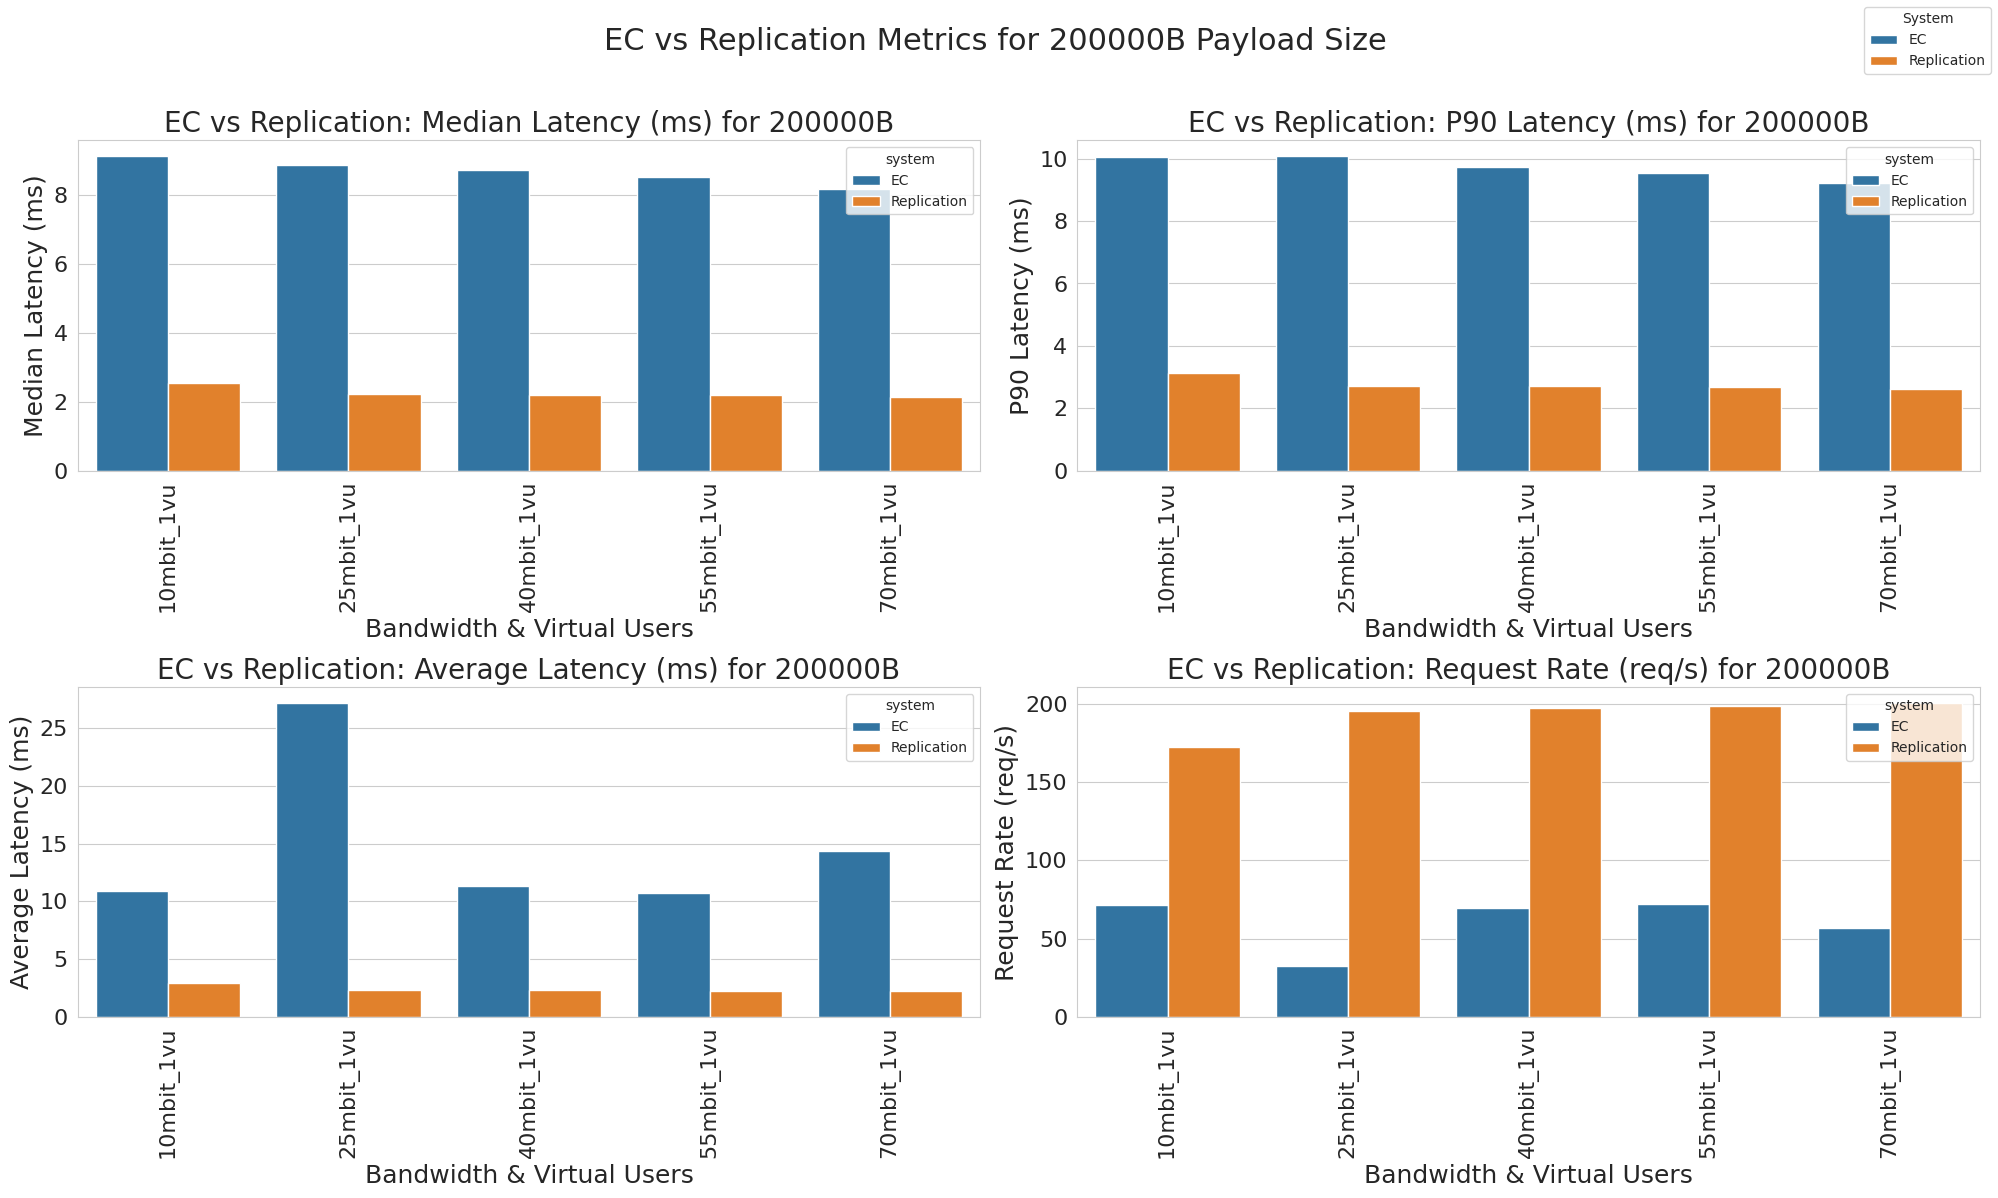

/tmp/ipykernel_350098/1566306490.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(
/tmp/ipykernel_350098/1566306490.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'], categories=x_order, ordered=True)
/tmp/ipykernel_350098/1566306490.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1566306490.py:28: FutureWarning: 

The

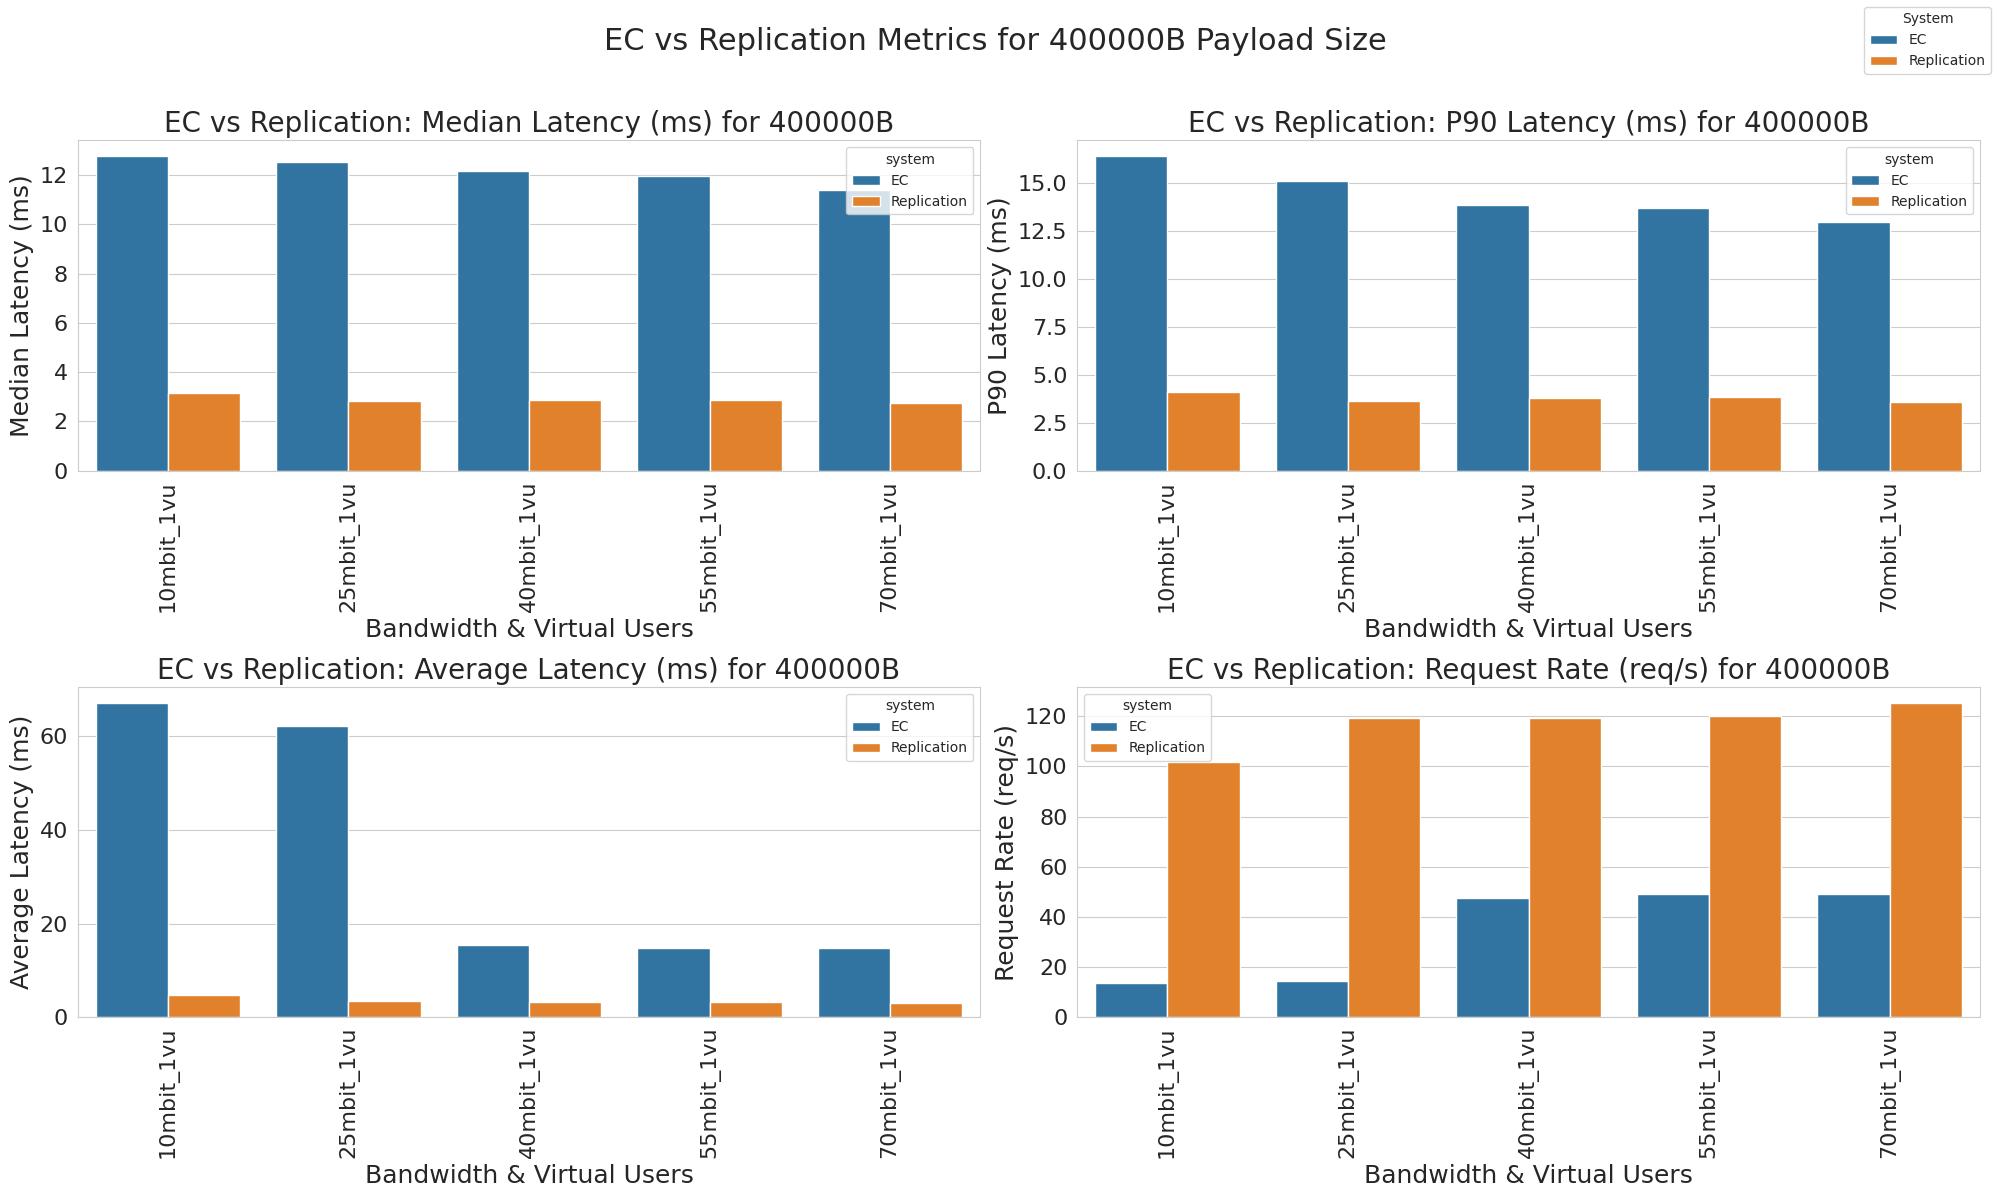

/tmp/ipykernel_350098/1566306490.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(
/tmp/ipykernel_350098/1566306490.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'], categories=x_order, ordered=True)
/tmp/ipykernel_350098/1566306490.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1566306490.py:28: FutureWarning: 

The

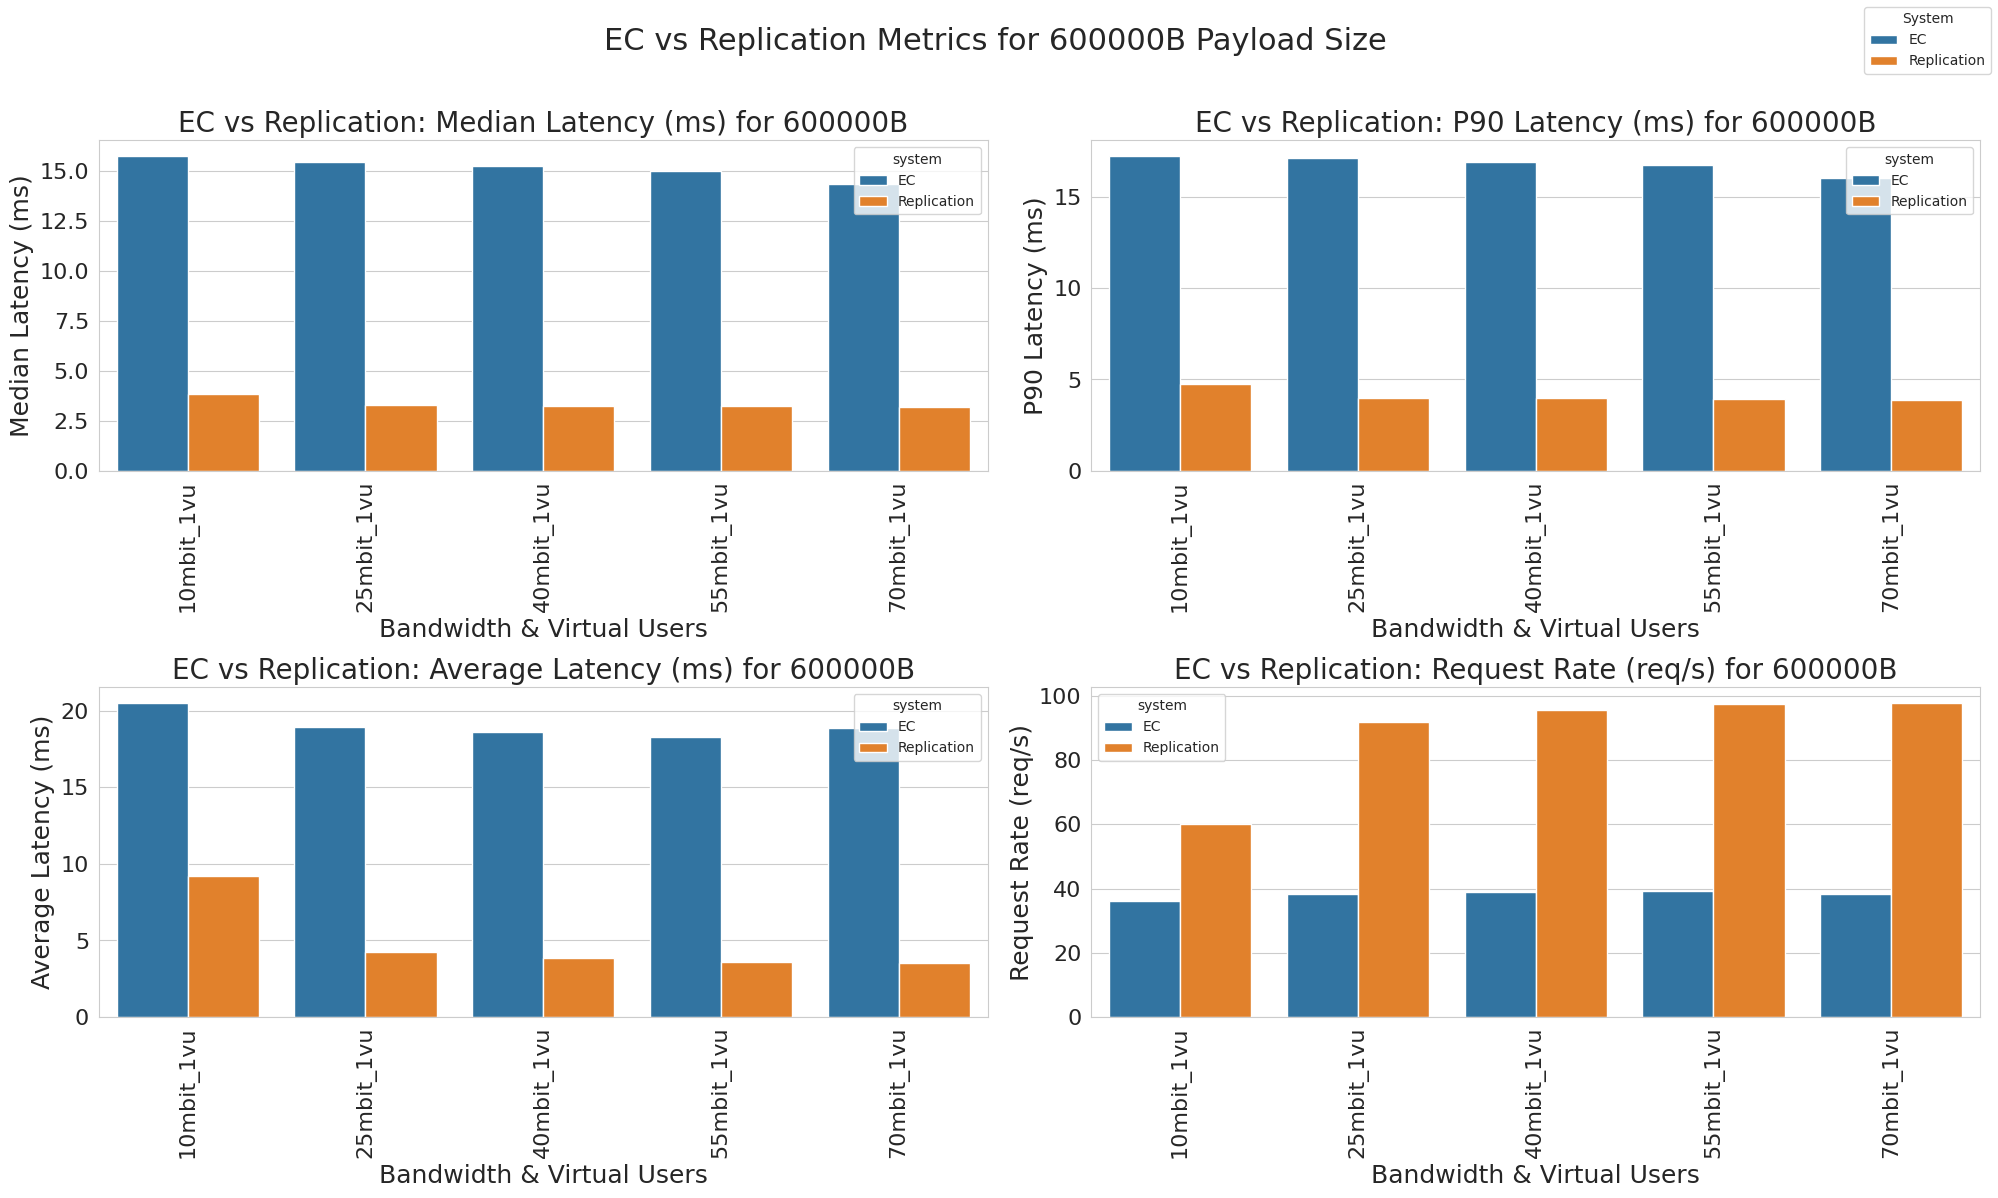

/tmp/ipykernel_350098/1566306490.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(
/tmp/ipykernel_350098/1566306490.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'], categories=x_order, ordered=True)
/tmp/ipykernel_350098/1566306490.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1566306490.py:28: FutureWarning: 

The

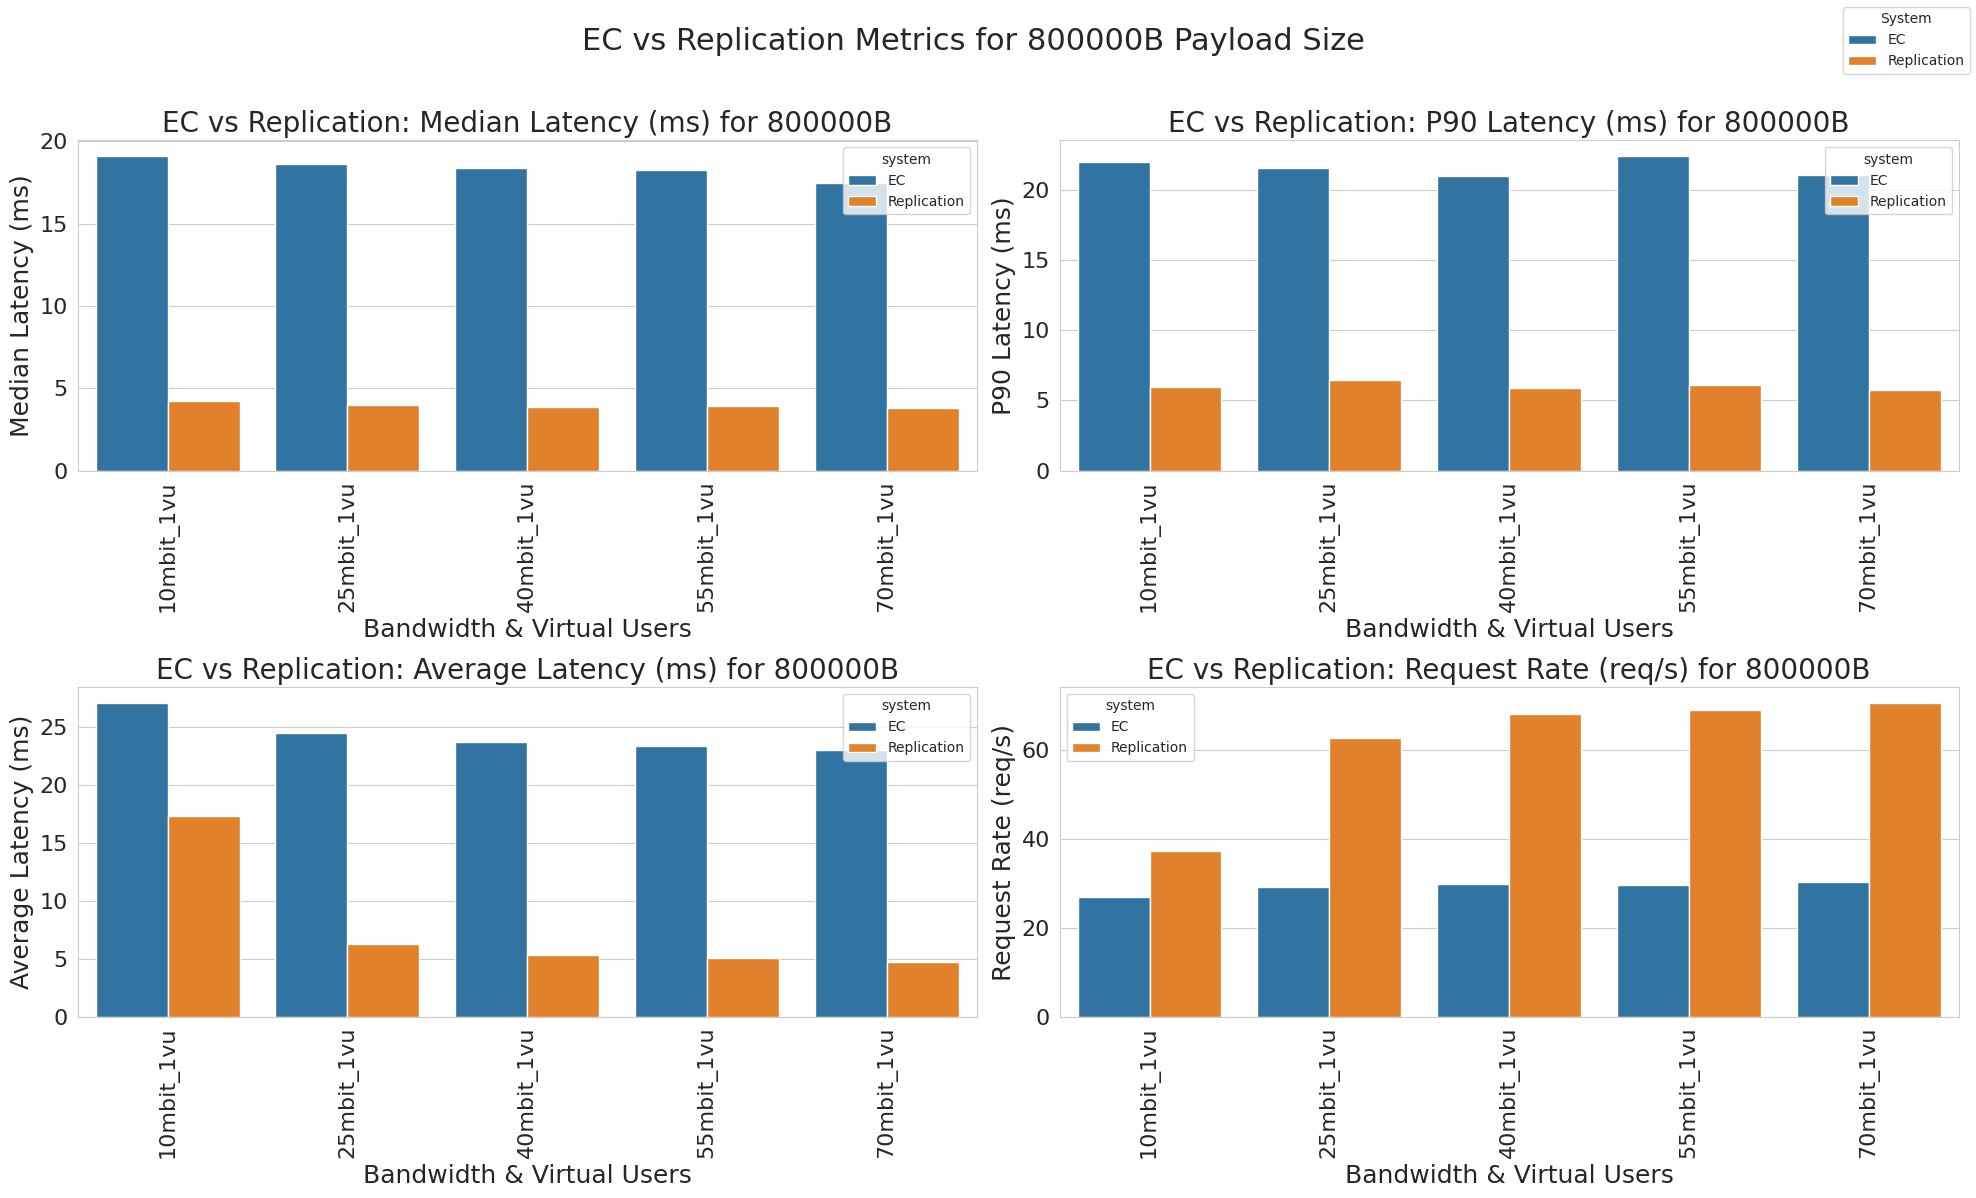

/tmp/ipykernel_350098/1566306490.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(
/tmp/ipykernel_350098/1566306490.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'], categories=x_order, ordered=True)
/tmp/ipykernel_350098/1566306490.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1566306490.py:28: FutureWarning: 

The

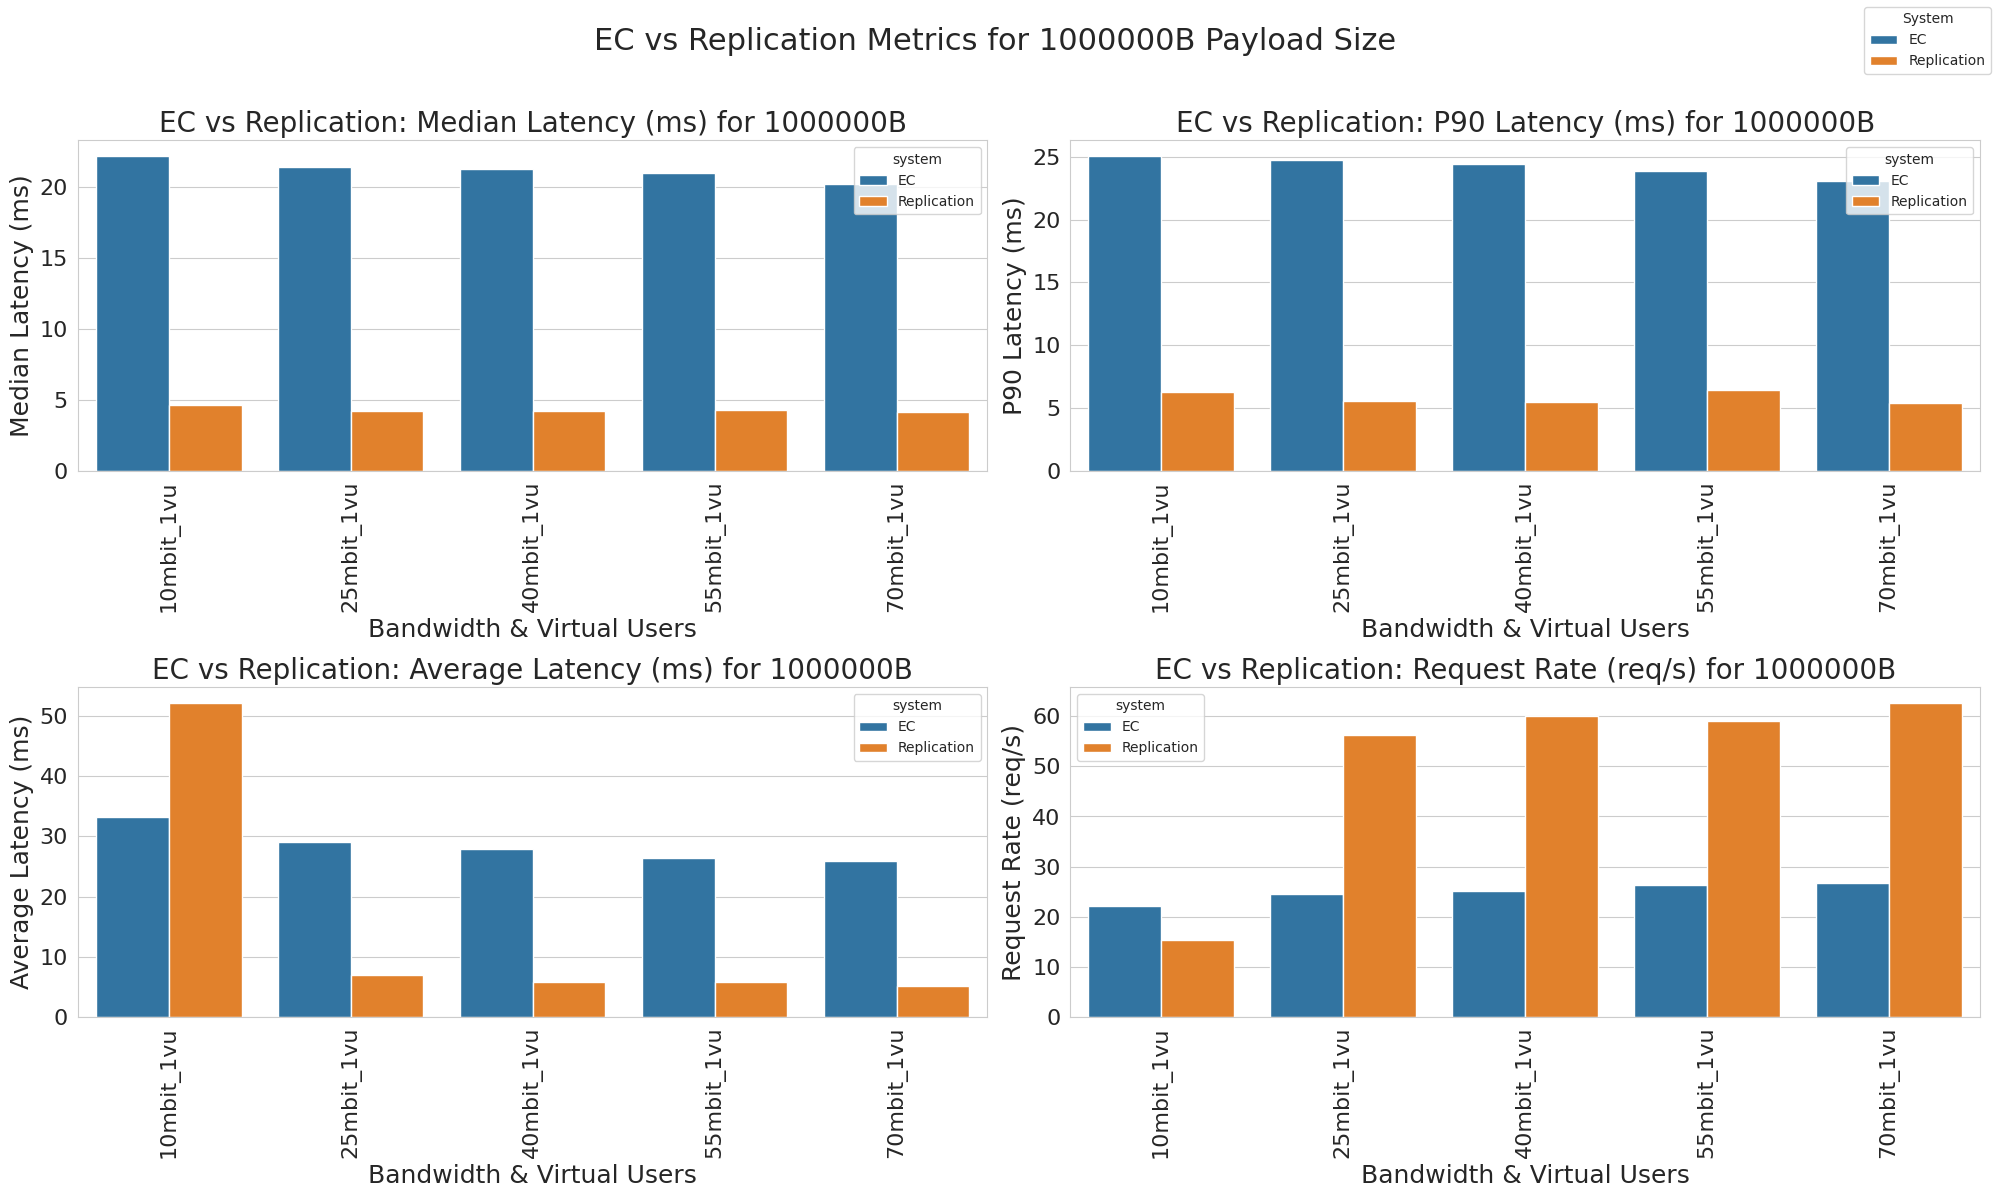

In [26]:
# 2. Grouping by payload size (all metrics in one 2 x 2 display)
def plot_by_payload():
    payloads = df['payload_size'].unique()
    for payload in payloads:
        df_payload = df[df['payload_size'] == payload]
        if df_payload.empty:
            continue

        # Sort bandwidths numerically for this payload
        bw_order = (
            df_payload[['bandwidth', 'bandwidth_num']]
            .drop_duplicates()
            .sort_values('bandwidth_num')
            .bandwidth.tolist()
        )
        # Create combined x‐axis labels and enforce ordering
        df_payload['bw_vu'] = df_payload.apply(
            lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1
        )
        vu_order = sorted(df_payload['virtual_user'].unique())
        x_order = [f"{bw}_{vu}vu" for bw in bw_order for vu in vu_order]
        df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'], categories=x_order, ordered=True)

        # set up 2 x 2 subplots for the four metrics
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        axes = axes.flatten()
        for ax, metric in zip(axes, metrics):
            sns.barplot(
                data=df_payload,
                x='bw_vu',
                y=metric,
                hue='system',
                ci=None,
                dodge=True,
                ax=ax
            )
            ax.set_title(f"EC vs Replication: {metric_titles[metric]} for {payload}B", fontsize=20)
            ax.set_xlabel("Bandwidth & Virtual Users", fontsize=18)
            ax.set_ylabel(metric_titles[metric], fontsize=18)
            ax.tick_params(axis='x', rotation=90, labelsize=16)
            ax.tick_params(axis='y', labelsize=16)

        # single legend for all subplots
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, title='System', loc='upper right')
        fig.suptitle(f"EC vs Replication Metrics for {payload}B Payload Size", fontsize=22)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

plot_by_payload()

/tmp/ipykernel_350098/1179877197.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1179877197.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1179877197.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_350098/1179877197.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


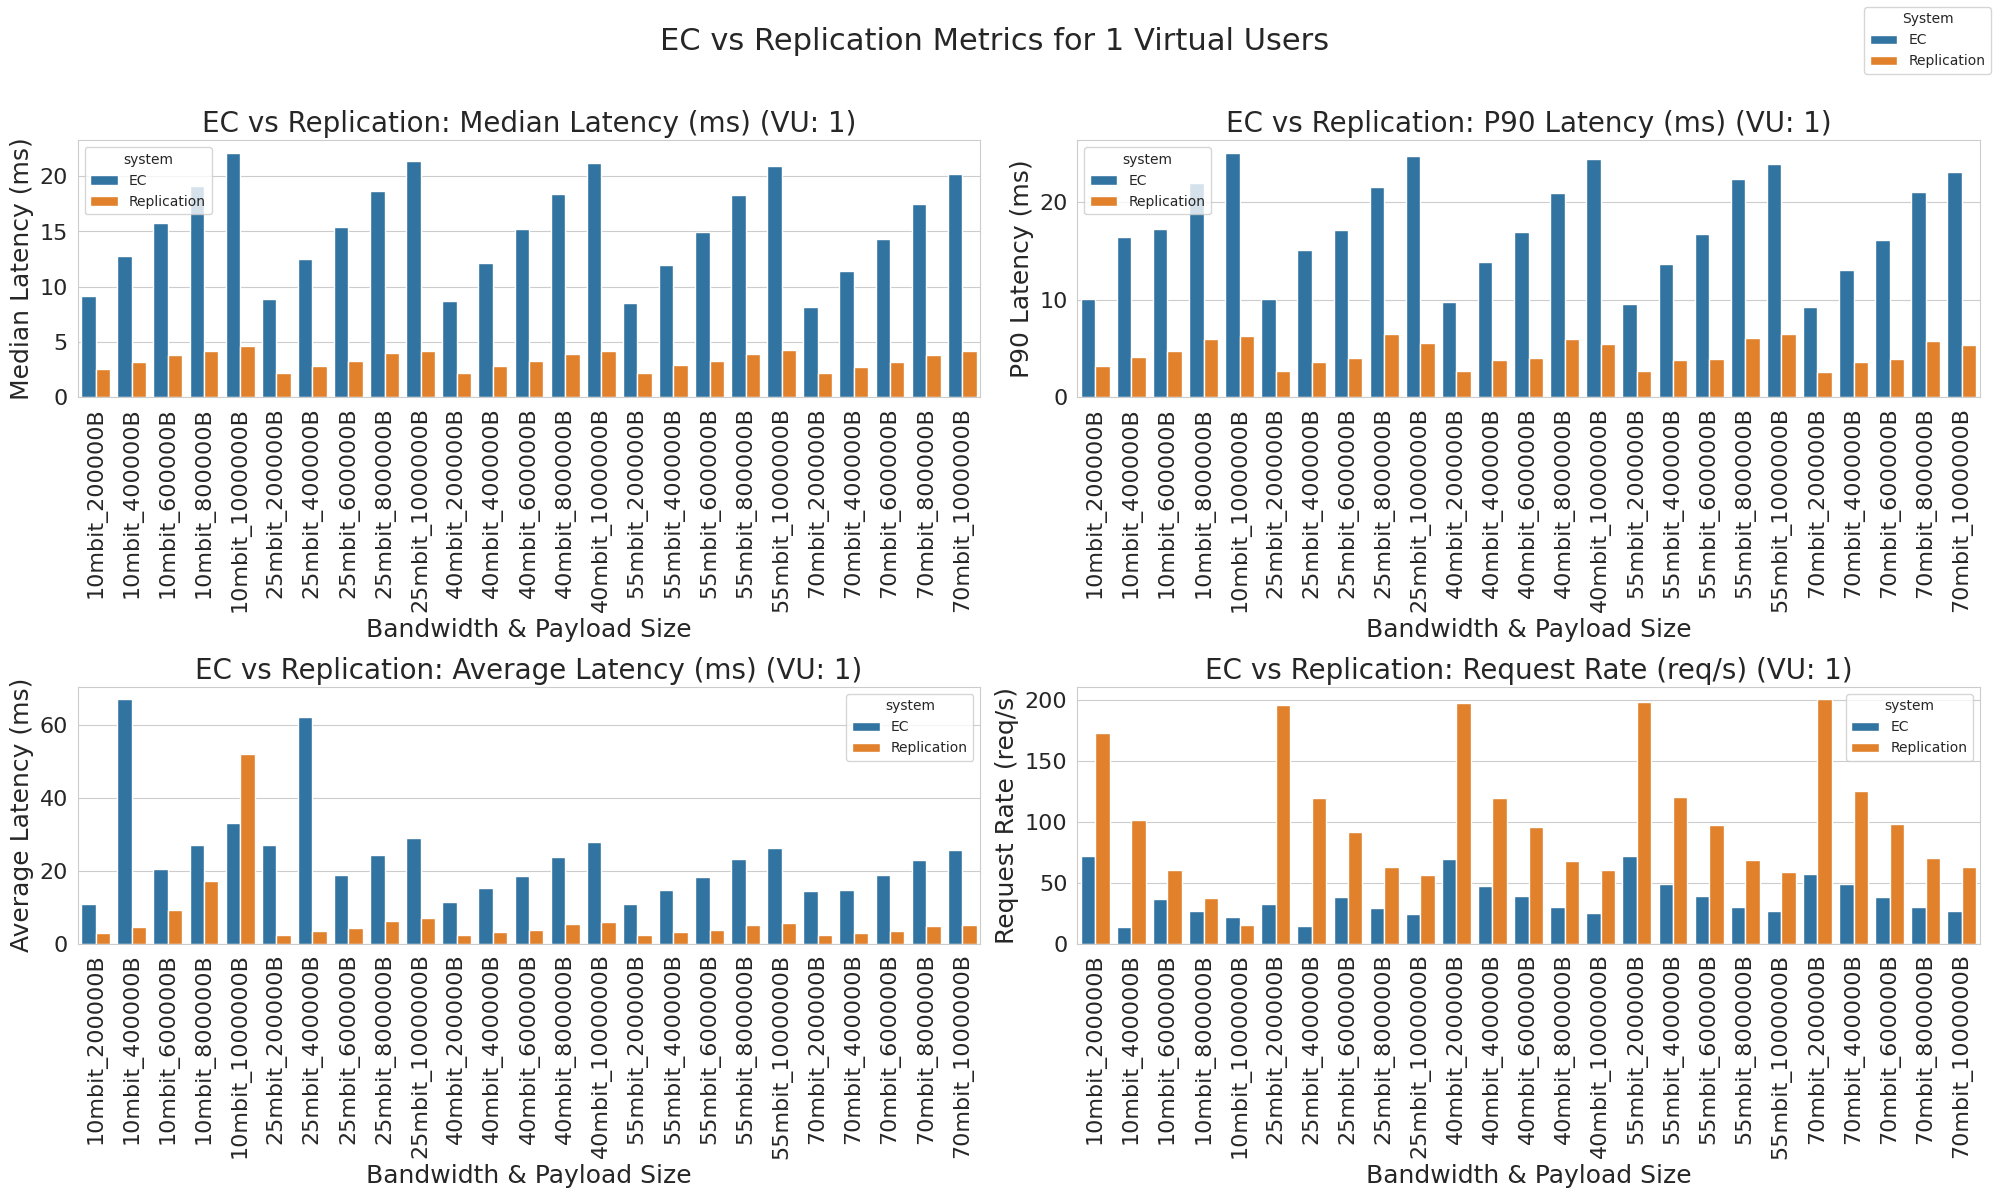

In [27]:
# 3. Grouping by virtual users (all metrics in one 2 x 2 display)
def plot_by_vu():
    vus = df['virtual_user'].unique()
    for vu in vus:
        df_vu = df[df['virtual_user'] == vu]
        if df_vu.empty:
            continue

        # set up 2 x 2 subplots for the four metrics
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        axes = axes.flatten()

        # precompute ordering for x‐axis
        bw_order = (
            df_vu[['bandwidth', 'bandwidth_num']]
            .drop_duplicates()
            .sort_values('bandwidth_num')
            .bandwidth.tolist()
        )
        ps_order = sorted(df_vu['payload_size'].unique())
        x_order = [f"{bw}_{ps}B" for bw in bw_order for ps in ps_order]

        # apply categorical ordering
        df_vu['bw_payload'] = df_vu.apply(
            lambda row: f"{row['bandwidth']}_{row['payload_size']}B", axis=1
        )
        df_vu['bw_payload'] = pd.Categorical(df_vu['bw_payload'], categories=x_order, ordered=True)

        for ax, metric in zip(axes, metrics):
            sns.barplot(
                data=df_vu,
                x='bw_payload',
                y=metric,
                hue='system',
                ci=None,
                dodge=True,
                ax=ax
            )
            ax.set_title(f"EC vs Replication: {metric_titles[metric]} (VU: {vu})", fontsize=20)
            ax.set_xlabel('Bandwidth & Payload Size', fontsize=18)
            ax.set_ylabel(metric_titles[metric], fontsize=18)
            ax.tick_params(axis='x', rotation=90, labelsize=16)
            ax.tick_params(axis='y', labelsize=16)

        # single legend for all subplots
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, title='System', loc='upper right')
        fig.suptitle(f"EC vs Replication Metrics for {vu} Virtual Users", fontsize=22)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

plot_by_vu()

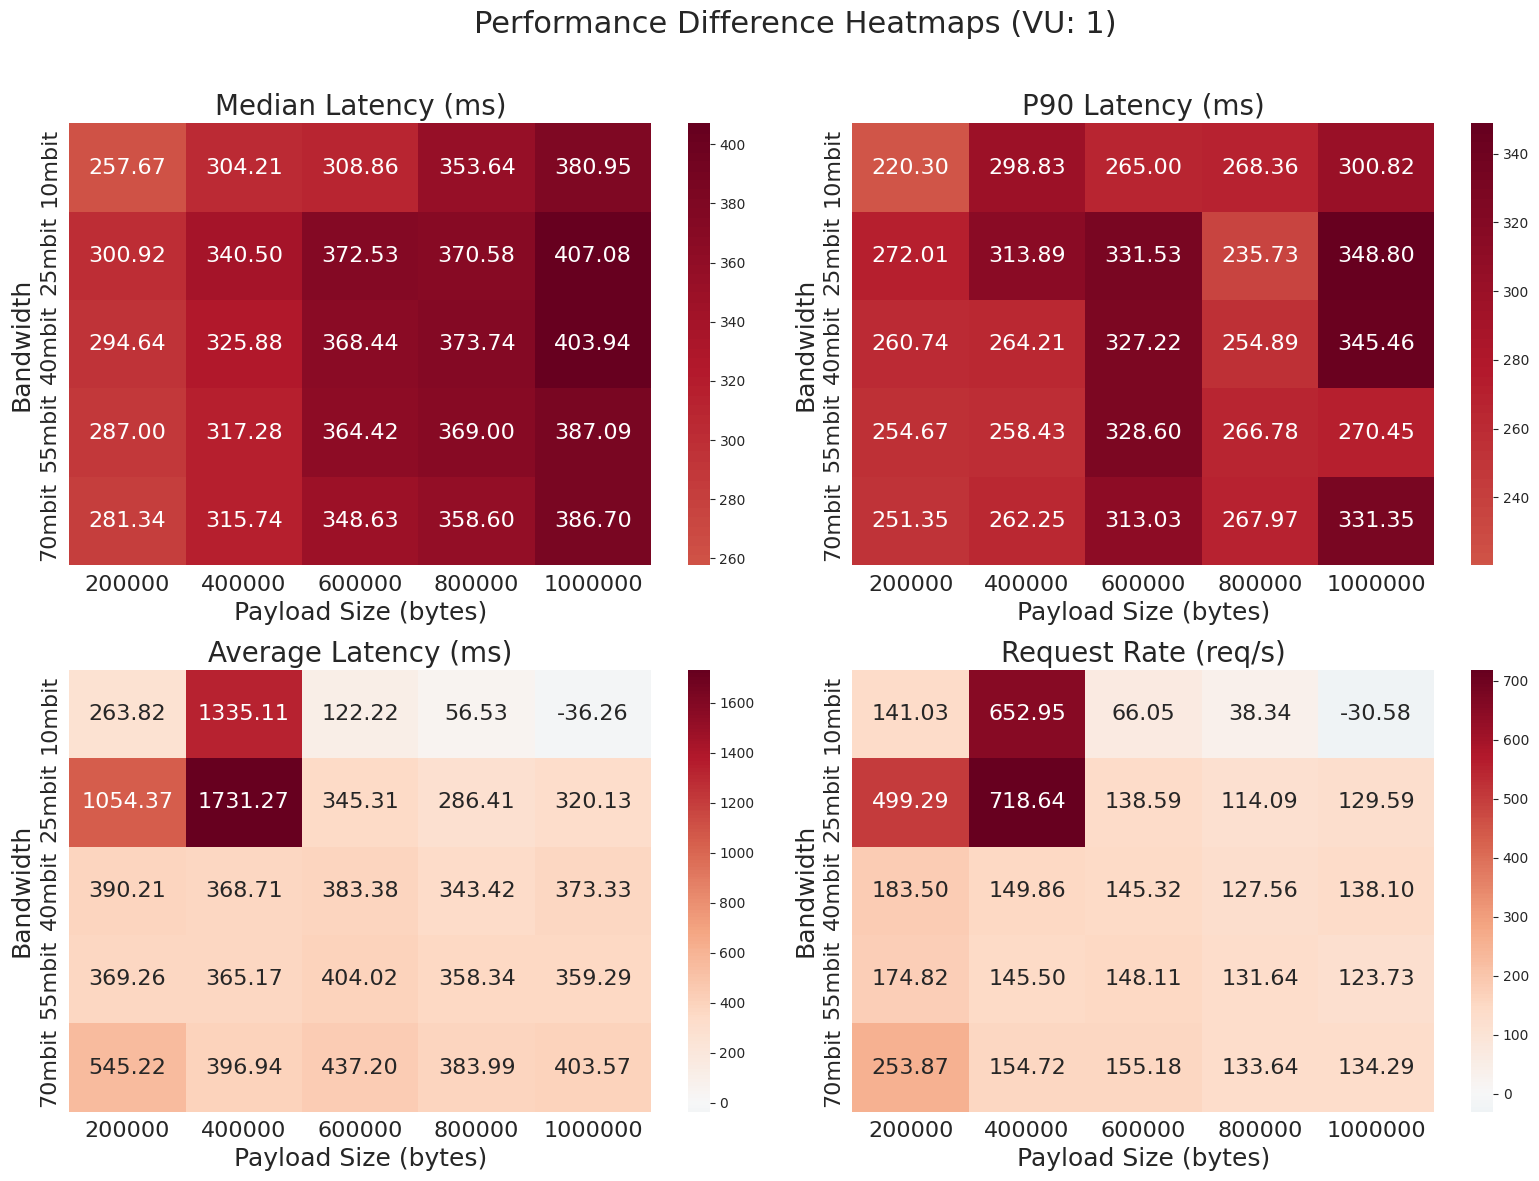

In [28]:
# 4. Create heatmaps to visualize the performance difference between EC and Replication
# This can help identify which configurations benefit most from EC vs Replication

def plot_heatmaps_by_vu():
    df_ec = df[df['system'] == 'EC'].copy()
    df_repl = df[df['system'] == 'Replication'].copy()
    common_conditions = pd.merge(
        df_ec[['payload_size','virtual_user','bandwidth','bandwidth_num']],
        df_repl[['payload_size','virtual_user','bandwidth','bandwidth_num']],
        on=['payload_size','virtual_user','bandwidth','bandwidth_num']
    )
    if common_conditions.empty:
        return

    df_ec_f = pd.merge(df_ec, common_conditions, on=['payload_size','virtual_user','bandwidth','bandwidth_num'])
    df_repl_f = pd.merge(df_repl, common_conditions, on=['payload_size','virtual_user','bandwidth','bandwidth_num'])

    for vu in sorted(common_conditions['virtual_user'].unique()):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        for ax, metric in zip(axes, metrics):
            diff_data = []
            df_ec_vu = df_ec_f[df_ec_f['virtual_user'] == vu]
            df_repl_vu = df_repl_f[df_repl_f['virtual_user'] == vu]
            for _, ec_row in df_ec_vu.iterrows():
                repl_row = df_repl_vu[
                    (df_repl_vu['payload_size'] == ec_row['payload_size']) &
                    (df_repl_vu['bandwidth'] == ec_row['bandwidth'])
                ].iloc[0]

                if metric in ['med', 'p90', 'avg']:
                    denom = repl_row[metric] if repl_row[metric] != 0 else 1
                    diff = (ec_row[metric] - repl_row[metric]) / denom * 100
                else:
                    denom = ec_row[metric] if ec_row[metric] != 0 else 1
                    diff = (repl_row[metric] - ec_row[metric]) / denom * 100

                diff_data.append({
                    'bandwidth': ec_row['bandwidth'],
                    'bandwidth_num': ec_row['bandwidth_num'],
                    'payload_size': ec_row['payload_size'],
                    'diff': diff
                })

            diff_df = pd.DataFrame(diff_data)
            bw_order = (
                diff_df[['bandwidth','bandwidth_num']]
                .drop_duplicates()
                .sort_values('bandwidth_num')
                ['bandwidth']
                .tolist()
            )
            pivot = diff_df.pivot(index='bandwidth', columns='payload_size', values='diff')\
                           .reindex(bw_order)

            sns.heatmap(pivot, annot=True, cmap='RdBu_r', center=0, fmt='.2f', ax=ax, annot_kws={'fontsize': 16})
            ax.set_title(metric_titles[metric], fontsize=20)
            ax.set_xlabel('Payload Size (bytes)', fontsize=18)
            ax.set_ylabel('Bandwidth', fontsize=18)
            ax.tick_params(axis='x', labelsize=16)
            ax.tick_params(axis='y', labelsize=16)

        fig.suptitle(f'Performance Difference Heatmaps (VU: {vu})', fontsize=22)
        plt.tight_layout(rect=[0,0,1,0.96])
        plt.show()

plot_heatmaps_by_vu()